<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>neural network architecture</a></span></li><li><span><a href="#data" data-toc-modified-id="data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#training" data-toc-modified-id="training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>results</a></span></li></ul></div>

# tl;dr

In this notebook we will try to make some experiments with the **Damped Harmonic Oscillator** (DHO) synthetic data. Here the goal is to explore the ability of the model to learn regions out of both locations and training domain.

# setup

In [56]:
import pprint
import functools
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

# neural network architecture

In [57]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;


$$ \ddot{x} + \frac{\mu}{m} \dot{x} + \frac{k}{m} x = 0 $$

# data

,time,displacement
0,0.000000,49.999996
1,0.040080,35.551117
2,0.080160,3.241474
3,0.120240,-26.105808
4,0.160321,-36.418770


<Axes: title={'center': 'Damped Harmonic Oscillator'}, xlabel='time'>

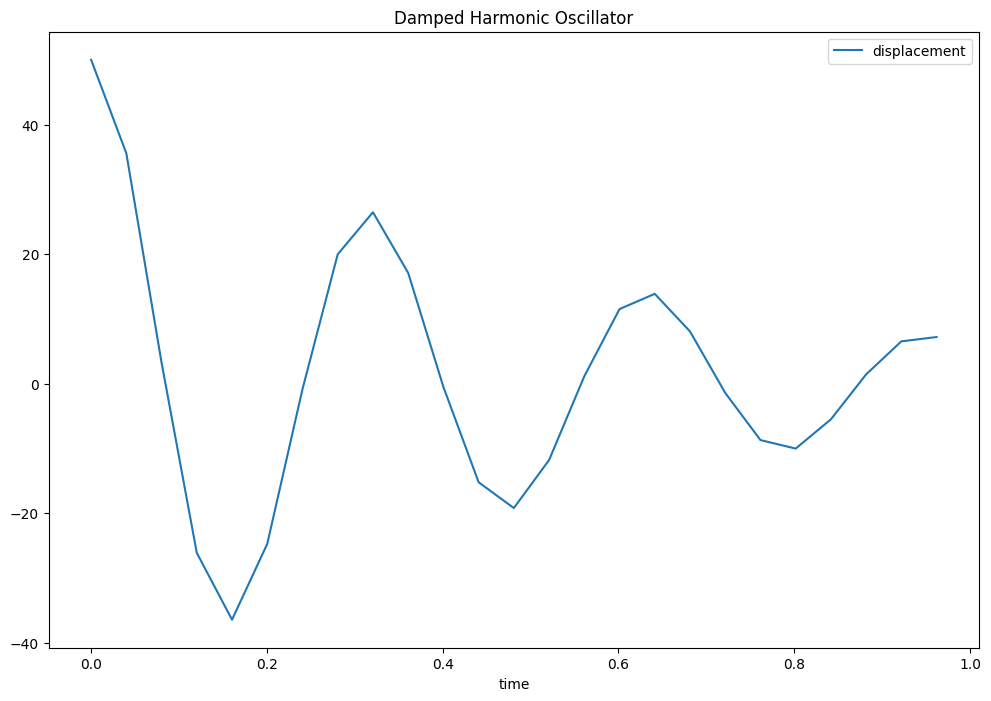

In [58]:
X = pd.read_csv("../data/01_raw/damped-harmonic-oscillator/extrapolation/train.csv").query("time <= 50")

# min_max_scaler = MinMaxScaler()
# X["time"] = min_max_scaler.fit_transform(X["time"].values.reshape(-1, 1))

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = 50 * exp*2*A*cos
    return y


d, w0 = 2, 20
x = torch.linspace(0, 1, 500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

X = pd.DataFrame({"time": x.squeeze()[0:500:20], "displacement": y.squeeze()[0:500:20]})

display(X.head())

X.plot(x="time", y="displacement", figsize=(12, 8), title="Damped Harmonic Oscillator")

# training

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|                                                 | 0/75000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|▌                                    | 1042/75000 [00:03<04:24, 279.56it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 343.401520, Physics Loss: 47281.117188, x0 Loss: 1261.257202, v0 Loss: 208.026764, Total Loss: 392.151947


  3%|█                                    | 2036/75000 [00:06<03:39, 332.40it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 36.125626, Physics Loss: 28285.507812, x0 Loss: 119.430222, v0 Loss: 534.117432, Total Loss: 65.064682


  4%|█▍                                   | 3020/75000 [00:11<06:15, 191.89it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 7.485747, Physics Loss: 17597.248047, x0 Loss: 10.323108, v0 Loss: 8.684013, Total Loss: 25.102001


  5%|█▉                                   | 4028/75000 [00:16<05:39, 209.03it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 3.726478, Physics Loss: 12635.399414, x0 Loss: 0.862943, v0 Loss: 4.382849, Total Loss: 16.367123


  7%|██▍                                  | 5040/75000 [00:21<05:42, 204.48it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 2.061658, Physics Loss: 7266.460449, x0 Loss: 0.006384, v0 Loss: 5.641510, Total Loss: 9.333768


  8%|██▉                                  | 6027/75000 [00:26<05:37, 204.57it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.934256, Physics Loss: 2754.124512, x0 Loss: 0.035734, v0 Loss: 12.988400, Total Loss: 3.701405


  9%|███▍                                 | 7035/75000 [00:31<05:41, 198.95it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.409970, Physics Loss: 2099.814697, x0 Loss: 0.105202, v0 Loss: 3.573740, Total Loss: 2.513463


 11%|███▉                                 | 8041/75000 [00:35<05:27, 204.75it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.228799, Physics Loss: 1559.309692, x0 Loss: 0.088845, v0 Loss: 0.678365, Total Loss: 1.788876


 12%|████▍                                | 9036/75000 [00:40<05:39, 194.06it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.130283, Physics Loss: 1114.302979, x0 Loss: 0.099951, v0 Loss: 0.127388, Total Loss: 1.244814


 13%|████▊                               | 10034/75000 [00:46<05:28, 197.93it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.090549, Physics Loss: 1010.980286, x0 Loss: 0.043012, v0 Loss: 0.021914, Total Loss: 1.101595


 15%|█████▎                              | 11030/75000 [00:50<05:25, 196.33it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.065086, Physics Loss: 651.003418, x0 Loss: 0.034839, v0 Loss: 0.270927, Total Loss: 0.716395


 16%|█████▊                              | 12030/75000 [00:55<04:39, 224.96it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.042392, Physics Loss: 760.415588, x0 Loss: 0.021737, v0 Loss: 1.455099, Total Loss: 0.804285


 17%|██████▎                             | 13042/75000 [01:00<04:34, 225.95it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.037203, Physics Loss: 583.852478, x0 Loss: 0.025002, v0 Loss: 0.000025, Total Loss: 0.621081


 19%|██████▋                             | 14035/75000 [01:05<04:56, 205.80it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.019064, Physics Loss: 277.821716, x0 Loss: 0.039300, v0 Loss: 0.065012, Total Loss: 0.296990


 20%|███████▏                            | 15028/75000 [01:09<05:15, 189.94it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.019926, Physics Loss: 239.858063, x0 Loss: 0.015436, v0 Loss: 0.003975, Total Loss: 0.259804


 21%|███████▋                            | 16041/75000 [01:14<04:42, 208.77it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.012259, Physics Loss: 185.636230, x0 Loss: 0.029089, v0 Loss: 0.162860, Total Loss: 0.198087


 23%|████████▏                           | 17055/75000 [01:18<03:32, 272.98it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.010233, Physics Loss: 156.478958, x0 Loss: 0.027344, v0 Loss: 0.195151, Total Loss: 0.166934


 24%|████████▋                           | 18063/75000 [01:21<02:48, 337.96it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.008913, Physics Loss: 134.100967, x0 Loss: 0.024785, v0 Loss: 0.221332, Total Loss: 0.143260


 25%|█████████▏                          | 19045/75000 [01:25<03:24, 273.10it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.008078, Physics Loss: 119.970619, x0 Loss: 0.024471, v0 Loss: 0.085429, Total Loss: 0.128159


 27%|█████████▌                          | 20047/75000 [01:29<03:24, 268.88it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.011316, Physics Loss: 145.492355, x0 Loss: 0.008586, v0 Loss: 0.031473, Total Loss: 0.156848


 28%|██████████                          | 21029/75000 [01:32<04:20, 207.15it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.006523, Physics Loss: 101.746826, x0 Loss: 0.024403, v0 Loss: 0.017274, Total Loss: 0.108312


 29%|██████████▌                         | 22021/75000 [01:38<04:30, 195.56it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.005789, Physics Loss: 79.493416, x0 Loss: 0.021416, v0 Loss: 0.257056, Total Loss: 0.085560


 31%|███████████                         | 23037/75000 [01:43<03:55, 220.89it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.005428, Physics Loss: 74.915718, x0 Loss: 0.023453, v0 Loss: 0.204029, Total Loss: 0.080571


 32%|███████████▌                        | 24035/75000 [01:48<04:25, 192.19it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.079576, Physics Loss: 10956.859375, x0 Loss: 0.079228, v0 Loss: 0.072342, Total Loss: 11.036587


 33%|████████████                        | 25024/75000 [01:52<03:43, 223.47it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.004825, Physics Loss: 57.834805, x0 Loss: 0.023393, v0 Loss: 0.192690, Total Loss: 0.062876


 35%|████████████▌                       | 26050/75000 [01:57<02:27, 332.91it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.006735, Physics Loss: 564.337158, x0 Loss: 0.028997, v0 Loss: 2.810906, Total Loss: 0.573912


 36%|████████████▉                       | 27042/75000 [02:00<02:46, 287.21it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.004671, Physics Loss: 48.933910, x0 Loss: 0.019902, v0 Loss: 0.239947, Total Loss: 0.053865


 37%|█████████████▍                      | 28046/75000 [02:04<02:49, 277.63it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.004345, Physics Loss: 46.153679, x0 Loss: 0.019715, v0 Loss: 0.275740, Total Loss: 0.050794


 39%|█████████████▉                      | 29024/75000 [02:08<03:11, 240.42it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.005162, Physics Loss: 139.906448, x0 Loss: 0.022412, v0 Loss: 0.468045, Total Loss: 0.145559


 40%|██████████████▍                     | 30022/75000 [02:12<03:41, 203.15it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.022367, Physics Loss: 2202.823730, x0 Loss: 0.027744, v0 Loss: 0.024227, Total Loss: 2.225242


 41%|██████████████▉                     | 31025/75000 [02:17<03:45, 195.31it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.009226, Physics Loss: 227.363861, x0 Loss: 0.005608, v0 Loss: 0.395799, Total Loss: 0.236991


 43%|███████████████▍                    | 32035/75000 [02:22<03:15, 219.38it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003847, Physics Loss: 36.278690, x0 Loss: 0.022963, v0 Loss: 0.205710, Total Loss: 0.040354


 44%|███████████████▊                    | 33030/75000 [02:27<03:33, 196.89it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.007145, Physics Loss: 432.209534, x0 Loss: 0.030161, v0 Loss: 0.259209, Total Loss: 0.439644


 45%|████████████████▎                   | 34036/75000 [02:32<03:24, 200.54it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.035404, Physics Loss: 5838.830078, x0 Loss: 0.000333, v0 Loss: 0.961151, Total Loss: 5.875196


 47%|████████████████▊                   | 35040/75000 [02:36<03:20, 199.76it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003558, Physics Loss: 33.112610, x0 Loss: 0.020005, v0 Loss: 0.248829, Total Loss: 0.036939


 48%|█████████████████▎                  | 36025/75000 [02:41<03:22, 192.93it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.004138, Physics Loss: 126.814720, x0 Loss: 0.021403, v0 Loss: 0.770231, Total Loss: 0.131744


 49%|█████████████████▊                  | 37022/75000 [02:46<03:18, 191.16it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003414, Physics Loss: 30.628553, x0 Loss: 0.021278, v0 Loss: 0.207799, Total Loss: 0.034272


 51%|██████████████████▎                 | 38040/75000 [02:52<03:04, 200.81it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003365, Physics Loss: 30.225283, x0 Loss: 0.019084, v0 Loss: 0.349963, Total Loss: 0.033960


 52%|██████████████████▋                 | 39023/75000 [02:57<03:05, 193.54it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003262, Physics Loss: 29.070753, x0 Loss: 0.020315, v0 Loss: 0.215711, Total Loss: 0.032568


 53%|███████████████████▏                | 40036/75000 [03:02<03:12, 182.05it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003178, Physics Loss: 28.332054, x0 Loss: 0.020211, v0 Loss: 0.187252, Total Loss: 0.031718


 55%|███████████████████▋                | 41024/75000 [03:07<03:06, 182.36it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003813, Physics Loss: 27.628113, x0 Loss: 0.010600, v0 Loss: 0.271675, Total Loss: 0.031723


 56%|████████████████████▏               | 42028/75000 [03:12<02:48, 195.42it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003163, Physics Loss: 28.099438, x0 Loss: 0.017327, v0 Loss: 0.197129, Total Loss: 0.031477


 57%|████████████████████▋               | 43038/75000 [03:18<02:47, 191.28it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.014646, Physics Loss: 2108.446289, x0 Loss: 0.005245, v0 Loss: 0.105198, Total Loss: 2.123203


 59%|█████████████████████▏              | 44039/75000 [03:23<02:37, 196.85it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002891, Physics Loss: 26.021675, x0 Loss: 0.018468, v0 Loss: 0.188596, Total Loss: 0.029120


 60%|█████████████████████▌              | 45046/75000 [03:28<02:07, 234.85it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002872, Physics Loss: 25.758980, x0 Loss: 0.018653, v0 Loss: 0.192975, Total Loss: 0.028843


 61%|██████████████████████              | 46053/75000 [03:32<01:45, 274.33it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002817, Physics Loss: 24.788904, x0 Loss: 0.017867, v0 Loss: 0.168609, Total Loss: 0.027792


 63%|██████████████████████▌             | 47033/75000 [03:37<02:22, 195.59it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002733, Physics Loss: 24.222681, x0 Loss: 0.017612, v0 Loss: 0.175066, Total Loss: 0.027148


 64%|███████████████████████             | 48022/75000 [03:42<02:20, 192.48it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002667, Physics Loss: 23.727888, x0 Loss: 0.017244, v0 Loss: 0.206425, Total Loss: 0.026619


 65%|███████████████████████▌            | 49020/75000 [03:47<02:11, 197.71it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002607, Physics Loss: 23.006189, x0 Loss: 0.017109, v0 Loss: 0.150872, Total Loss: 0.025781


 67%|████████████████████████            | 50035/75000 [03:52<02:04, 200.38it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002755, Physics Loss: 111.114410, x0 Loss: 0.013424, v0 Loss: 0.116448, Total Loss: 0.114000


 68%|████████████████████████▍           | 51035/75000 [03:57<02:11, 182.76it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002573, Physics Loss: 24.951267, x0 Loss: 0.015365, v0 Loss: 0.082961, Total Loss: 0.027623


 69%|████████████████████████▉           | 52026/75000 [04:02<01:53, 202.22it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002573, Physics Loss: 29.065054, x0 Loss: 0.015860, v0 Loss: 0.020040, Total Loss: 0.031674


 71%|█████████████████████████▍          | 53023/75000 [04:07<01:54, 191.89it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003033, Physics Loss: 34.514893, x0 Loss: 0.011134, v0 Loss: 0.152417, Total Loss: 0.037712


 72%|█████████████████████████▉          | 54033/75000 [04:12<01:45, 198.78it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002316, Physics Loss: 20.381599, x0 Loss: 0.015426, v0 Loss: 0.120970, Total Loss: 0.022834


 73%|██████████████████████████▍         | 55054/75000 [04:17<01:21, 245.13it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.004741, Physics Loss: 85.900040, x0 Loss: 0.004763, v0 Loss: 0.007267, Total Loss: 0.090653


 75%|██████████████████████████▉         | 56034/75000 [04:22<01:37, 193.73it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.003493, Physics Loss: 94.312660, x0 Loss: 0.003481, v0 Loss: 0.445431, Total Loss: 0.098255


 76%|███████████████████████████▎        | 57024/75000 [04:27<01:31, 196.18it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.004763, Physics Loss: 240.119934, x0 Loss: 0.004774, v0 Loss: 0.435135, Total Loss: 0.245323


 77%|███████████████████████████▊        | 58040/75000 [04:31<01:11, 236.39it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.005607, Physics Loss: 238.348938, x0 Loss: 0.000118, v0 Loss: 0.106658, Total Loss: 0.244063


 79%|████████████████████████████▎       | 59031/75000 [04:35<01:01, 260.49it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.006107, Physics Loss: 741.420166, x0 Loss: 0.005226, v0 Loss: 0.000245, Total Loss: 0.747532


 80%|████████████████████████████▊       | 60027/75000 [04:39<00:55, 269.37it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001830, Physics Loss: 48.973991, x0 Loss: 0.008500, v0 Loss: 0.594934, Total Loss: 0.051407


 81%|█████████████████████████████▎      | 61018/75000 [04:43<01:02, 224.62it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002411, Physics Loss: 31.590969, x0 Loss: 0.005529, v0 Loss: 0.192882, Total Loss: 0.034201


 83%|█████████████████████████████▊      | 62023/75000 [04:48<01:04, 202.06it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002488, Physics Loss: 69.362877, x0 Loss: 0.009396, v0 Loss: 0.190846, Total Loss: 0.072051


 84%|██████████████████████████████▎     | 63052/75000 [04:53<00:47, 254.10it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.008279, Physics Loss: 584.140747, x0 Loss: 0.002985, v0 Loss: 0.503316, Total Loss: 0.592926


 85%|██████████████████████████████▋     | 64039/75000 [04:57<00:56, 193.36it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.002640, Physics Loss: 85.263168, x0 Loss: 0.007093, v0 Loss: 0.221619, Total Loss: 0.088132


 87%|███████████████████████████████▏    | 65039/75000 [05:01<00:48, 203.98it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001690, Physics Loss: 27.809504, x0 Loss: 0.010268, v0 Loss: 0.099960, Total Loss: 0.029610


 88%|███████████████████████████████▋    | 66022/75000 [05:06<00:42, 211.21it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001960, Physics Loss: 100.186241, x0 Loss: 0.002924, v0 Loss: 0.918419, Total Loss: 0.103068


 89%|████████████████████████████████▏   | 67039/75000 [05:11<00:39, 200.02it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001507, Physics Loss: 31.247719, x0 Loss: 0.005977, v0 Loss: 0.035452, Total Loss: 0.032796


 91%|████████████████████████████████▋   | 68027/75000 [05:15<00:34, 202.18it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001263, Physics Loss: 17.018131, x0 Loss: 0.008124, v0 Loss: 0.112712, Total Loss: 0.018402


 92%|█████████████████████████████████▏  | 69022/75000 [05:20<00:29, 200.67it/s]

mass =  1.0 damping =  4.0 spring =  400.0
Data Loss: 0.001537, Physics Loss: 31.684389, x0 Loss: 0.005699, v0 Loss: 0.110297, Total Loss: 0.033337


 93%|█████████████████████████████████▎  | 69473/75000 [05:22<00:25, 215.09it/s]


DONE!


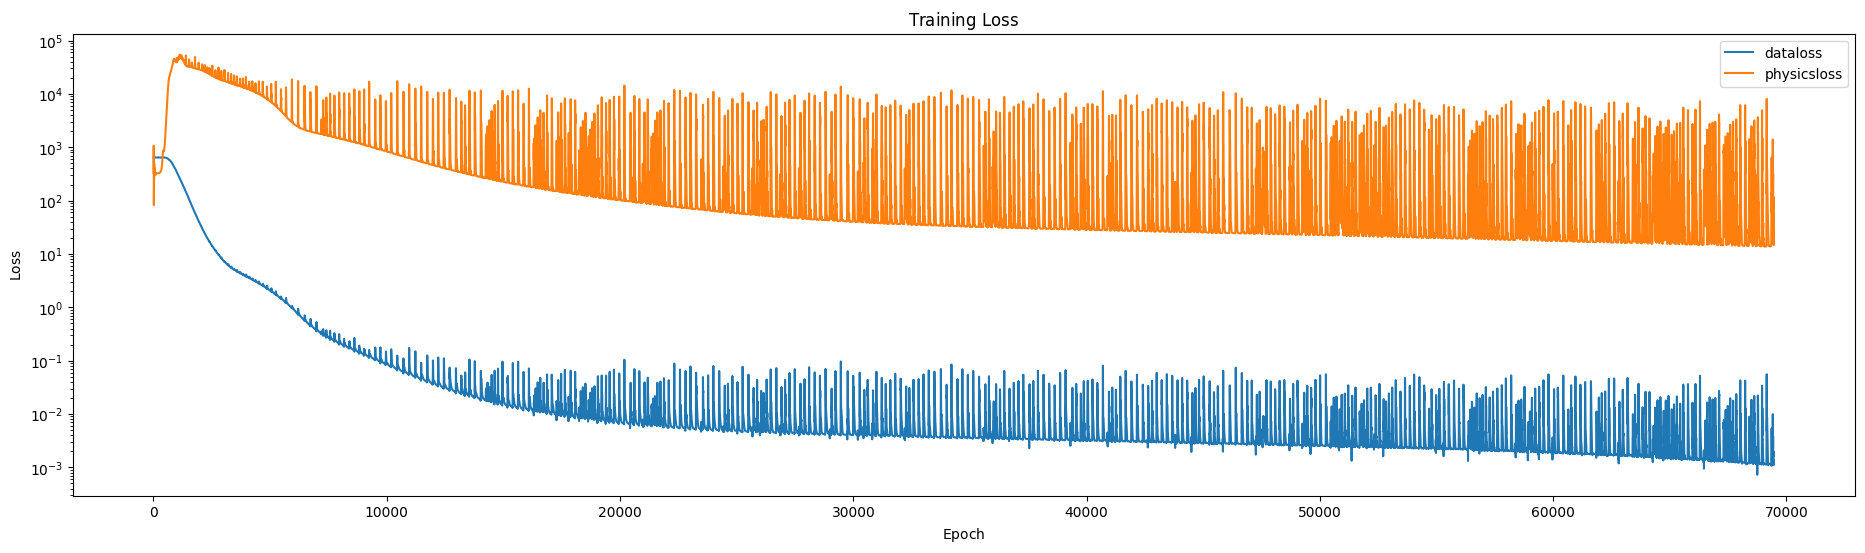

In [79]:
m = 1
# k = 1
# mu = 0.1
mu, k = 2*d, w0**2
x_0 = 1
v_0 = 0

torch.manual_seed(123)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query("time <= 0.5")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query("time <= 0.5")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query("time > 0.5")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query("time > 0.5")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 3,
    'n_neurons': 32,
    'num_epochs': 75000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

model = MultiLayerPerceptronRegressor(architecture, nn.GELU)
model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[])

_locations = torch.linspace(0, 0.75, 50).view(-1,1).requires_grad_(True).to(device)
_m = torch.tensor(m, dtype=torch.float, requires_grad=False).to(device)
_mu = torch.tensor(mu, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(k, dtype=torch.float, requires_grad=False).to(device)
_x0 = torch.tensor(X["displacement"][0], dtype=torch.float, requires_grad=False).to(device)
_v0 = torch.tensor(v_0, dtype=torch.float, requires_grad=False).to(device)

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
    dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]

    _x0_loss = criterion(y_location_hat[0], _x0)
    _v0_loss = criterion(dydt[0], _v0)

    _diff_equation = _m*dy2dt2 + _mu*dydt + _k*y_location_hat
    
    physics_loss = criterion(_diff_equation, torch.zeros_like(_diff_equation))

    loss = data_loss + (1e-3)*(physics_loss) + (1e-3)*(_x0_loss) + (1e-3)*(_v0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print("mass = ", _m.item(), "damping = ", _mu.item(), "spring = ", _k.item())
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, x0 Loss: {_x0_loss.item():.6f}, v0 Loss: {_v0_loss.item():.6f}, Total Loss: {loss.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
    
    if loss.item() <= 0.015:
        print("DONE!")
        break

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss", figsize=(23, 6), ax=ax1)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

ax1.set_yscale('log')

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss_pinn.png", dpi=300, bbox_inches="tight") ;

# results

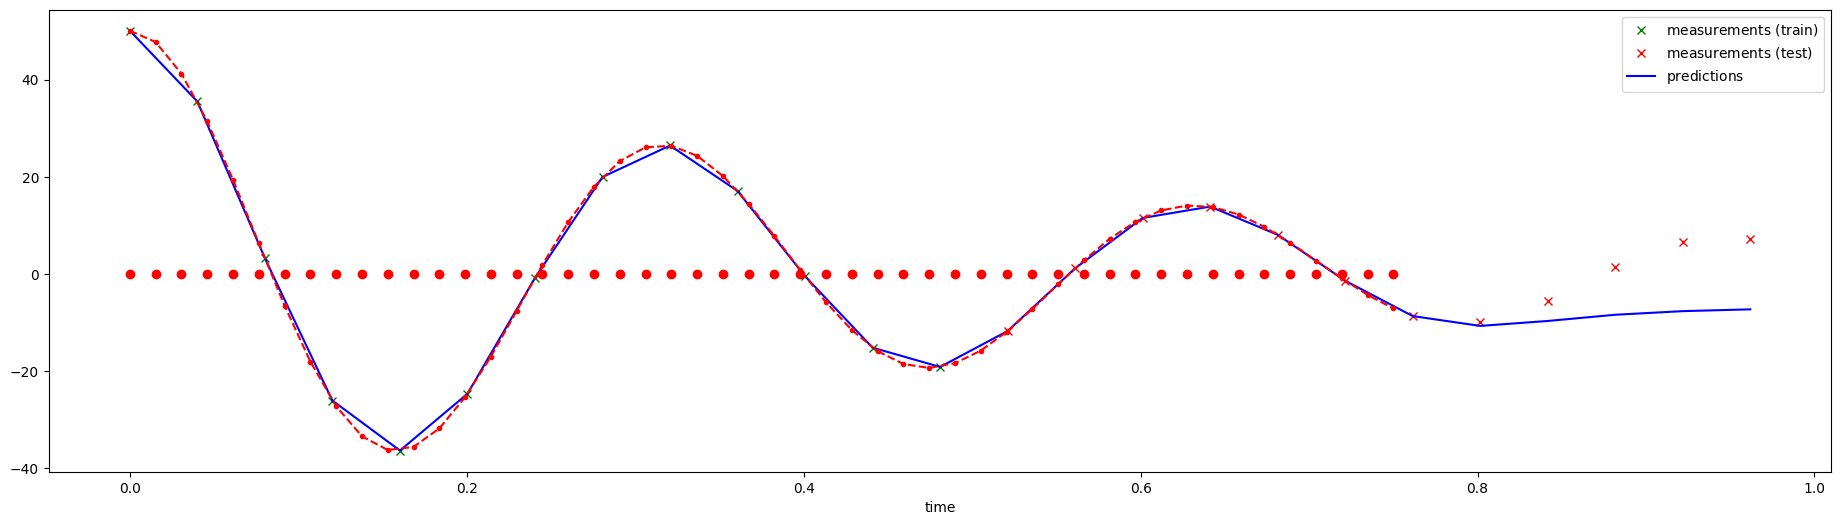

In [83]:
model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 0.5").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 0.5").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
)

# # plot theoretical curve
# m = 1
# k = 1
# mu = 0.1
# x_0 = 1
# v_0 = 0

# omega_0 = np.sqrt(k/m)
# delta = mu/(2*m)
# omega = np.sqrt(omega_0**2 - delta**2)

# t = np.linspace(0, 50, 1000)
# x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
# ax1.plot(
#     t.reshape(-1, 1),
#     x, 
#     c="k", linestyle="--", 
#     label=r"$\text{exact solution}$"
# )

# ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
# ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
# ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

# plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
# ax1.legend()

# plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions_pinn.png", dpi=300, bbox_inches="tight") ;

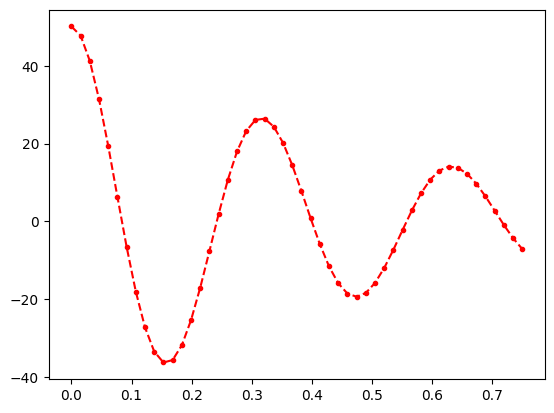

In [84]:
model.eval()
with torch.no_grad():
    plt.plot(
        _locations.cpu().detach().numpy().reshape(-1, 1),
        model(_locations).cpu().detach().numpy().reshape(-1), 
        c="r", linestyle="--", marker=".",
        label=r"$\text{locations prediction}$"
    )

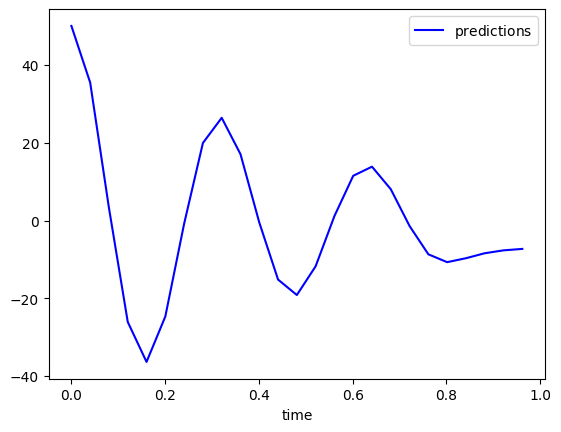

In [85]:
X.plot(
    x="time", 
    y="y_hat",
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
) ;

.